In [7]:
import numpy as np
import matplotlib.pyplot as plt

import pulp as lp
import itertools
import copy
from tqdm import tqdm, tqdm_notebook


In [2]:
# Offline optimal to calculate regret
def offline_optimal_action(W, mu):
    
    action = np.ones_like(mu[:,0]) * -1
    
    C = np.append(mu,np.zeros([mu.shape[0],1]),axis=1)
    
    num_user = mu[:,0].shape[0]
    num_server = mu[0,:].shape[0]
    
    prob = lp.LpProblem("prob",lp.LpMaximize)
    
    # Import pulp and make decision variables
    dec_var = []
    for u,s in itertools.product(range(num_user),range(num_server+1)):
        dec_var += [(u,s-1)]

    X = lp.LpVariable.dicts("x", dec_var,lowBound=0,upBound = 1, cat='Integer')

    # Make Constraints - 1 pull per user
    usr_constraint = []
    for u in range(num_user):
        usr_constraint += [0]

    for u,s in itertools.product(range(num_user),range(num_server+1)):
        usr_constraint[u] += X[(u,s-1)]

    for u in range(num_user):
        prob += (usr_constraint[u] == 1)

    # Make constraint - 1 user per server
    svr_constraint = []

    for s in range(num_server):
        svr_constraint += [0]

    for u,s in itertools.product(range(num_user),range(num_server)):
        svr_constraint[s] += X[(u,s)]

    for s in range(num_server):
        prob += (svr_constraint[s] <= 1)

    # Make objective function
    obj = 0
    for u,s in itertools.product(range(num_user),range(num_server+1)):
        obj += W[u,s-1] * C[u,s-1] * X[(u,s-1)]
    prob += obj

    status = prob.solve(lp.PULP_CBC_CMD(msg=0))
    
    X2 = copy.deepcopy(X)

    for key in X2.keys():
        if X2[key].value() > 0:
            u,s = key
            action[u] = s
    
    rwd = 0
    
    for u in range(num_user):
        rwd += W[u, int(action[u])]* C[u,int(action[u])]
        
    new_action = []
    for i in range(action.shape[0]):
        new_action += [int(action[i])]
    
    return new_action, rwd

def pull_super_arm(arms, mus, rewards_record, pulls_record ):
    """
    arms - u x 1, vector, ith-element is user i, indicates which arm they will pull
    return - rewards of each arm drawn from bernoulli distribution 
    """
    
    for i in range(len(arms)): # looping through clients
        n = 1
        p = mus[i,arms[i]]
        s = np.random.binomial(n, p, 1)
        rewards_record[i,arms[i]] += [s]
        pulls_record[i,arms[i]] += 1
    return rewards_record, pulls_record
    
def update_ucb(reward_record, pulls_record, ucb, T, L=2):
    """
    Update decision variables for next round
    """
    
    num_users, num_svrs = reward_record.shape[0], reward_record.shape[1]
    for u in range(num_users):
        for s in range(num_svrs):
            if pulls_record[u,s] > 0:
                mean = reward_record[u,s]/pulls_record[u,s]
            else:
                mean = 0
            
            cb = np.sqrt(L * np.log(T)/ pulls_record[u,s])
            
            ucb[u,s] = mean + cb
    
    return ucb

    
def sweep_init_next(lst, num_svrs):
    for i in range(len(lst)):
        lst[i] += 1
        lst[i] = lst[i]%(num_svrs)
    
    return lst

def expected_reward(arms, mus, w):
    exp_mus = np.zeros(len(arms))
    for i in range(len(arms)):
        exp_mus[i] = w[i, arms[i]]* mus[i, arms[i]]
        
    return np.sum(exp_mus)

In [11]:
# System Parameters
T = 5000 * 2
num_users = 10
num_svrs = 15
mu = np.random.uniform(low=0, high = 1, size = [num_users, num_svrs])
w = np.random.uniform(low=0, high=1, size= [num_users, num_svrs])

# Recorded Values
rewards_record = np.zeros([num_users,num_svrs])
pulls_record = np.zeros([num_users,num_svrs])
ucb = np.zeros([num_users,num_svrs])
# optimal = offline_optimal_action(w, mu)
regret = np.zeros(T)

In [12]:
# Initial Stages -- TS = servers, rotating 
arms = list(range(num_users)) 
# w = np.random.uniform(low=0, high=1, size= [num_users, num_svrs])
# optimal = offline_optimal_action(w, mu)

for i in range(num_svrs):
    w = np.random.uniform(low=0, high=1, size= [num_users, num_svrs])
    optimal = offline_optimal_action(w, mu)
    rewards_record, pulls_record = pull_super_arm(arms, mu, rewards_record, pulls_record)
    regret[i] = optimal[1] - expected_reward(arms, mu, w)
    arms = sweep_init_next(arms, num_svrs)
    
for (zzz,t) in zip(tqdm_notebook(range(i+1, T)),range(i+1, T)):
    w = np.random.uniform(low=0, high=1, size= [num_users, num_svrs])
    optimal = offline_optimal_action(w, mu)
    ucb = update_ucb(rewards_record, pulls_record, ucb, t, 1)
    arms = offline_optimal_action(w, ucb)[0]
    rewards_record, pulls_record = pull_super_arm(arms, mu, rewards_record, pulls_record)
    regret[t] = optimal[1] - expected_reward(arms, mu, w)

Text(0, 0.5, 'Regret')

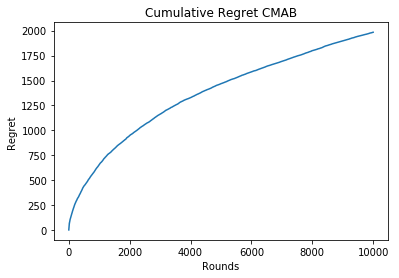

In [13]:
plt.plot(np.cumsum(regret))
plt.title('Cumulative Regret CMAB')
plt.xlabel('Rounds')
plt.ylabel('Regret')

Text(0, 0.5, 'Regret')

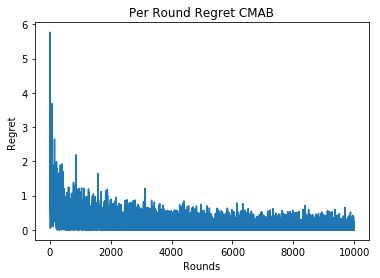

In [14]:
plt.plot(regret)
plt.title('Per Round Regret CMAB')
plt.xlabel('Rounds')
plt.ylabel('Regret')

In [60]:
regret[T-500:]

array([ 2.68506652e-02,  1.72445264e-01,  8.44728146e-02, -8.88178420e-16,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        5.02075881e-02, -1.77635684e-15,  2.19495158e-02, -8.88178420e-16,
        0.00000000e+00,  5.85570905e-02,  0.00000000e+00,  8.88178420e-16,
        1.26122204e-03,  7.80288357e-02,  8.88178420e-16,  0.00000000e+00,
        8.88178420e-16,  6.61309336e-04,  6.77244836e-02,  1.23662651e-02,
        3.69502830e-03,  0.00000000e+00,  0.00000000e+00,  5.13258807e-02,
        9.33225472e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.88527475e-03, -8.88178420e-16,  3.73925352e-02,  0.00000000e+00,
        6.97002573e-02,  0.00000000e+00,  2.29513528e-02,  4.29564609e-02,
        0.00000000e+00, -8.88178420e-16,  0.00000000e+00,  0.00000000e+00,
        2.59040469e-02,  9.50074303e-02,  3.48446965e-03,  6.55858707e-02,
        1.56981319e-01,  0.00000000e+00,  0.00000000e+00,  3.42486224e-02,
       -8.88178420e-16,  

In [15]:
print(optimal[0])
print(arms)

[14, 4, 6, 7, 2, 12, 13, 10, 0, 1]
[14, 4, 6, 7, 2, 12, 13, 10, 0, 1]


In [68]:
# estimated parameters
update_ucb(rewards_record, pulls_record, ucb, i, 0)[1]

array([0.66546438, 0.25892857, 0.57624398, 0.6036036 , 0.04545455,
       0.60322953, 0.        , 0.98198739, 0.20512821, 0.46195652,
       0.74076561, 0.48484848, 0.6781158 , 0.        , 0.04347826])

In [69]:
# Real parameters
mu[1]

array([0.66289327, 0.22229353, 0.58949061, 0.59912608, 0.1102458 ,
       0.59469044, 0.03079697, 0.98417654, 0.21208574, 0.45506221,
       0.75569856, 0.48408783, 0.67730733, 0.12038735, 0.09441667])

In [72]:
pulls_record[1]

array([1109.,  112.,  623.,  555.,   22.,  867.,   23., 3331.,   39.,
        368., 1489.,  396., 1019.,   24.,   23.])